In [1]:
!nvidia-smi

Tue May 12 16:46:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install tensorflow-gpu >> /dev/null

In [0]:
!pip install --upgrade grpcio >> /dev/null
!pip install bert-for-tf2 >> /dev/null
!pip install tqdm  >> /dev/null
!pip install sentencepiece >> /dev/null

In [4]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data 

In [5]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 52.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 64.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 74.5MB/s]


In [0]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [0]:
train = train.append(valid).reset_index(drop = True)

In [8]:
train.shape

(13784, 2)

In [9]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


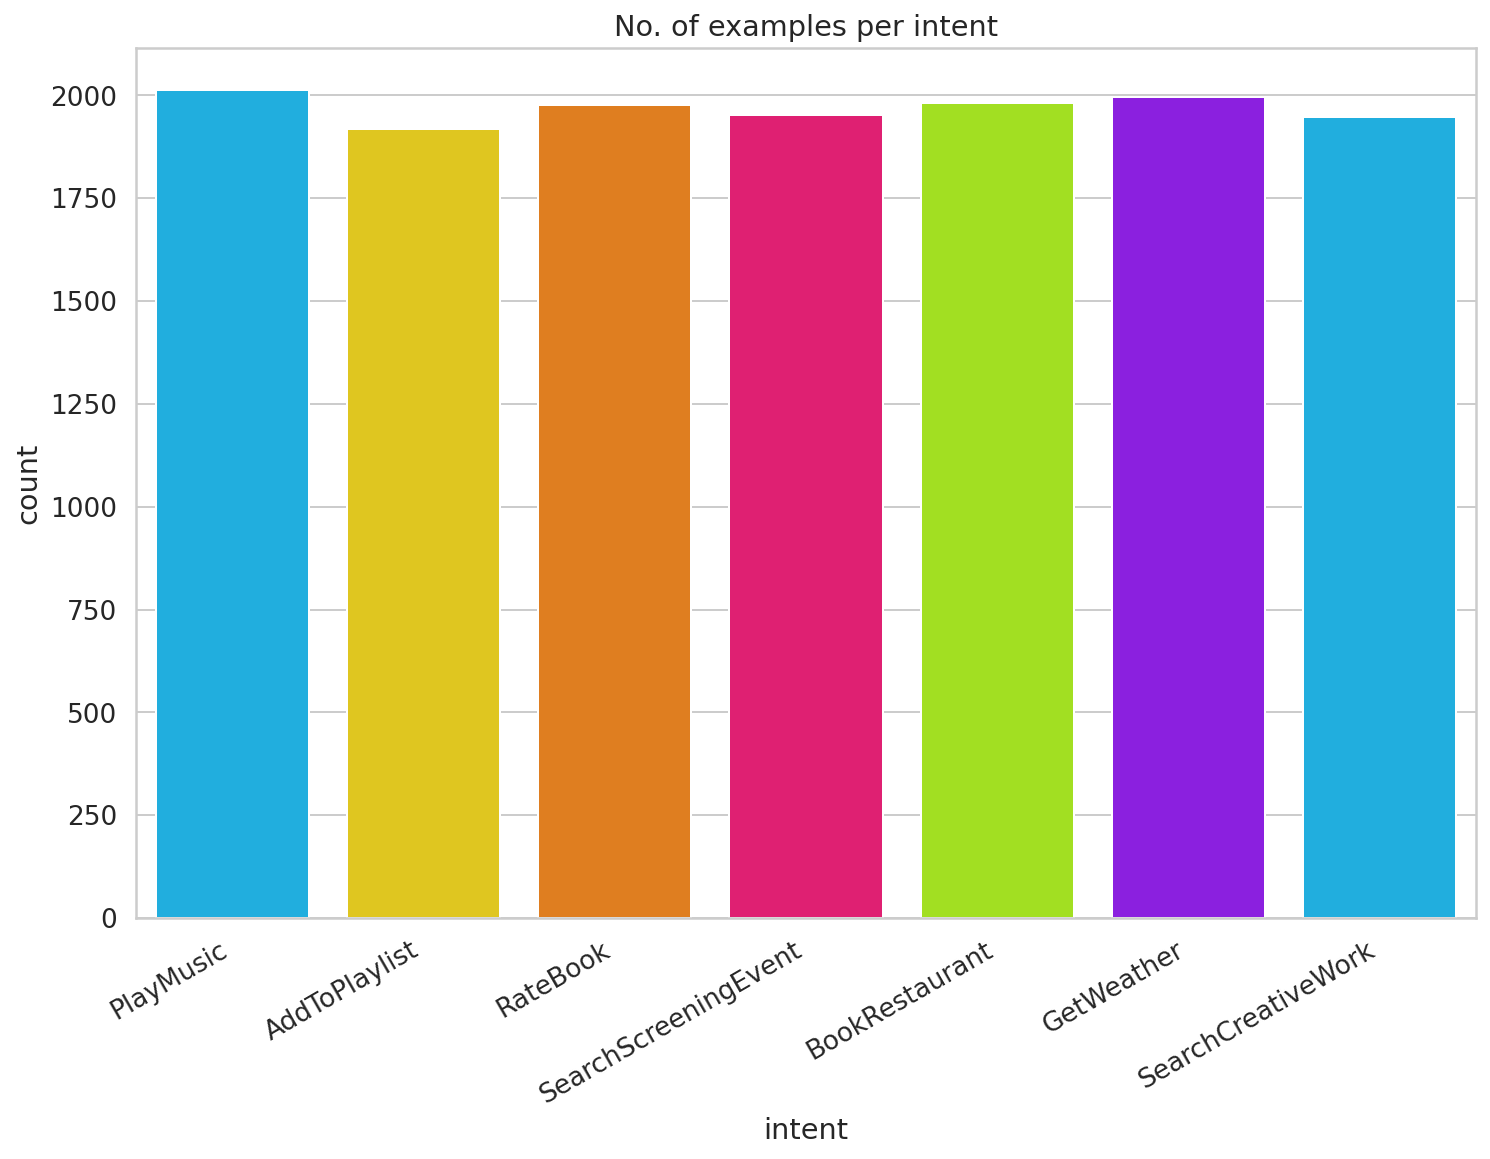

In [10]:
chart =   sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title('No. of examples per intent')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment = 'right');

# Bert Intent Recognition

In [11]:
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2020-05-12 16:48:39--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M  79.2MB/s    in 8.4s    

2020-05-12 16:48:48 (75.6 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [12]:
!unzip multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs('model', exist_ok=True)

In [0]:
!mv multi_cased_L-12_H-768_A-12/ model

In [0]:
bert_model_name = 'multi_cased_L-12_H-768_A-12'
bert_ckpt_dir = os.path.join('model/', bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file =os.path.join(bert_ckpt_dir, 'bert_config.json')

#Pre Processing

In [0]:
class intentRecogntion:
  TEXT = 'text'
  LABEL = 'intent'

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[intentRecogntion.TEXT], row[intentRecogntion.LABEL]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))
    
    np.array(y)
    y =tf.keras.utils.to_categorical(y)
    return np.array(x), y
  def _pad(self, ids):

    padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(ids, 
                                                                  maxlen = self.max_seq_len,
                                                                  truncating='post',
                                                                  padding='post')

    return padded_inputs

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, 'vocab.txt'), do_lower_case= False)

In [0]:
#tokens = tokenizer.tokenize('Lets go to Japan')
#print(tokens)

In [0]:
#tokenizer.convert_tokens_to_ids(tokens)


In [0]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
      #bert.apply_adapter_freeze()
      bert.embeddings_layer.trainable = False
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [20]:
classes = train.intent.unique().tolist()
print(classes)
data = intentRecogntion(train, test, tokenizer, classes, max_seq_len=128)

358it [00:00, 3575.04it/s]

['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent', 'BookRestaurant', 'GetWeather', 'SearchCreativeWork']


13784it [00:03, 3804.73it/s]
700it [00:00, 3610.15it/s]

max seq_len 40


In [21]:
model = create_model(data.max_seq_len,  bert_ckpt_file)

bert shape (None, 40, 768)
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fc750692ef0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [22]:
print(data.train_x.shape)
print(data.train_x[36])
print(data.train_y.shape)

(13784, 40)
[  101 12976   187 10105 35660 10106 15127 14978 28504 10105 11940 10662
 19132 10667 21454   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
(13784, 7)


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 40)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 40, 768)           177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [0]:
model.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [25]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir) 

history = model.fit(
    data.train_x, 
    data.train_y,
    validation_split = 0.1,
    batch_size = 16,
    shuffle = True,
    epochs = 5,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
776/776 [==============================] - 129s 166ms/step - loss: 1.3275 - accuracy: 0.8426 - val_loss: 1.1896 - val_accuracy: 0.9746
Epoch 2/5
776/776 [==============================] - 128s 165ms/step - loss: 1.1879 - accuracy: 0.9786 - val_loss: 1.1850 - val_accuracy: 0.9797
Epoch 3/5
776/776 [==============================] - 128s 165ms/step - loss: 1.1840 - accuracy: 0.9819 - val_loss: 1.1805 - val_accuracy: 0.9848
Epoch 4/5
776/776 [==============================] - 129s 166ms/step - loss: 1.1845 - accuracy: 0.9812 - val_loss: 1.1815 - val_accuracy: 0.9833
Epoch 5/5
776/776 [==============================] - 128s 165ms/step - loss: 1.1814 - accuracy: 0.9844 - val_loss: 1.1850 - val_accuracy: 0.9804


In [26]:
_, test_acc = model.evaluate(data.test_x, data.test_y)
print(test_acc)

22/22 [==============================] - 2s 105ms/step - loss: 1.1950 - accuracy: 0.9700
0.9700000286102295


In [0]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [0]:
#print(classification_report(data.test_y, y_pred, target_names=classes))

In [29]:
sentences = [
            'Play our song now',
            'Rate this book as very bad',
            'Is it raining outside?',
            'Pluere quod est foris',
            'Nos ludere canticum nunc',
            'Non sic omnino liber sum, illud I rate stella,',
            'Reserve a table for four',
            'Speel nou ons musiek',
            'Nunc nostrorum musicorum ludere',
            'Look for the the wildest party happening in town'
]

tokens = map(tokenizer.tokenize, sentences)
tokens = map(lambda tok: ['[CLS]'] + tok + ['[SEP]'], tokens)
token_ids = list(map(tokenizer.convert_tokens_to_ids, tokens))
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(token_ids, 
                                                              maxlen = 40,
                                                              truncating='post',
                                                              padding='post')

predictions = model.predict(padded_inputs).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Play our song now 
intent: PlayMusic

text: Rate this book as very bad 
intent: RateBook

text: Is it raining outside? 
intent: GetWeather

text: Pluere quod est foris 
intent: GetWeather

text: Nos ludere canticum nunc 
intent: GetWeather

text: Non sic omnino liber sum, illud I rate stella, 
intent: RateBook

text: Reserve a table for four 
intent: BookRestaurant

text: Speel nou ons musiek 
intent: SearchCreativeWork

text: Nunc nostrorum musicorum ludere 
intent: PlayMusic

text: Look for the the wildest party happening in town 
intent: SearchCreativeWork



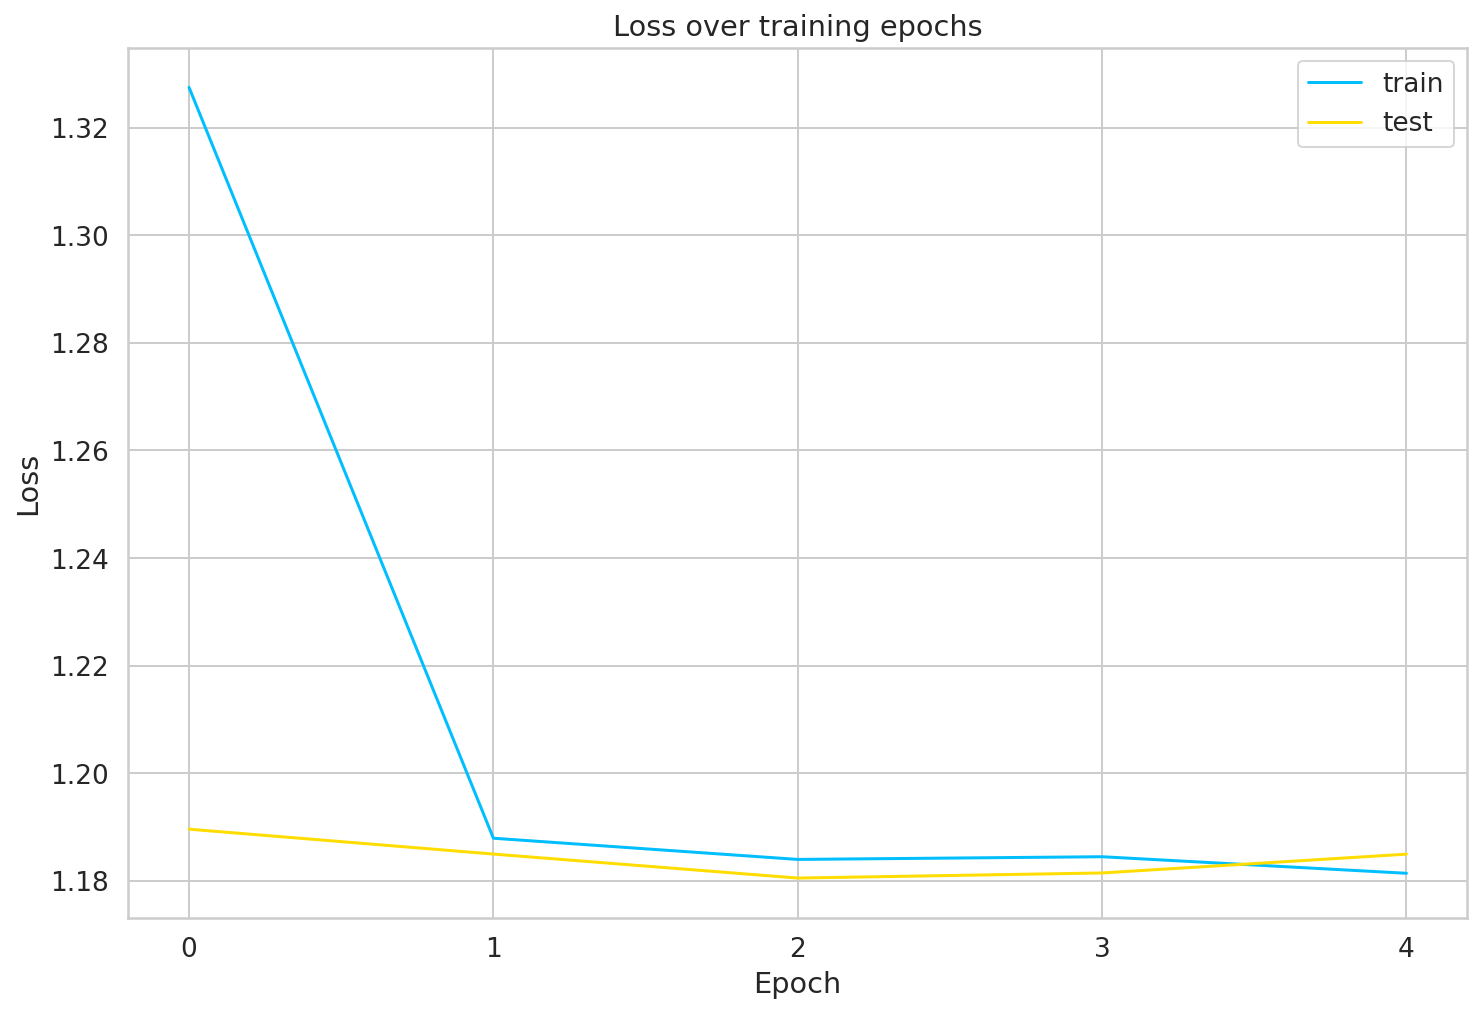

In [30]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

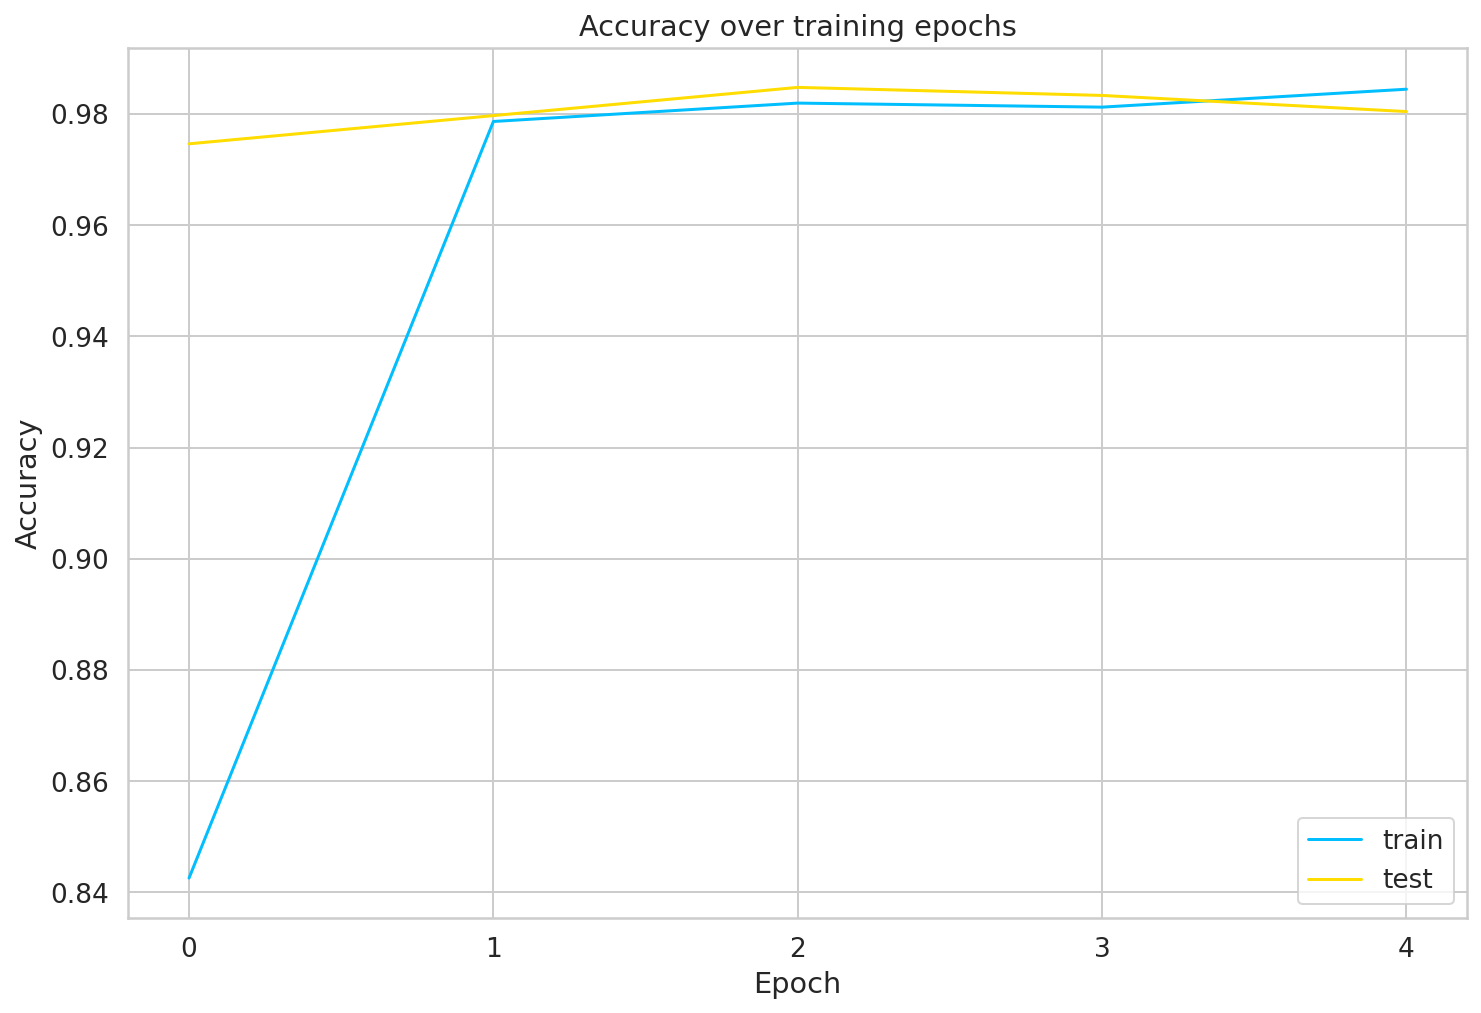

In [31]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();